Load the scripts for predicting using the ConvNet model

In [1]:
from os import getcwd, path
import matplotlib.pyplot as plt
import numpy as np

BASE_PATH = getcwd()

DATA_UTILS = path.join(BASE_PATH, 'data_utils.py')
CONV_MODEL = path.join(BASE_PATH, 'convnet/predict.py')
DATA_UTILS = path.join(BASE_PATH, 'data_utils.py')

exec(open(DATA_UTILS).read())
exec(open(CONV_MODEL).read())
exec(open(DATA_UTILS).read())

/Users/2359media/anaconda/envs/botbot-nlp/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Load files necessary for inference to cache

In [11]:
MODEL_PATH = path.join(BASE_PATH, 'convnet/model/model.h5')
TOKENIZER_PATH = path.join(BASE_PATH, 'convnet/model/tokenizer.pickle')
CLASSES_PATH = path.join(BASE_PATH, 'convnet/model/classes.json')

model = load_saved_model(MODEL_PATH, ignore_cache=True)
tokenizer = load_tokenizer(TOKENIZER_PATH, ignore_cache=True)
classes = load_classes(CLASSES_PATH, ignore_cache=True)

Test the loaded model:
- run_predict() returns a matrix of prediction results, accepts a list of texts or a singular string
- interpret_netout() is a generator which loops through the results and return a tuple of class name and probability

In [12]:
next(interpret_netout(run_predict('My baby has a fever')))

('Baby Care - Medical - Fever', 81.87417984008789)

Try to run samples through the model to see false evaluations
This will help isolate the examples that make the model confused

In [4]:
TRAIN_PATH = path.join(BASE_PATH, 'kc_data.json')
X_data, y_data = get_data_pairs(data_from_json(TRAIN_PATH))

result = list(interpret_netout(run_predict(X_data)))

cell_text = []
for (idx, (result_class, proba)) in list(enumerate(result)):
    if y_data[idx] != result_class:
        cell_text.append([X_data[idx], y_data[idx], result_class, proba])

Found 656 (accuracy: -5.4) misassigned examples. Showing the top 40


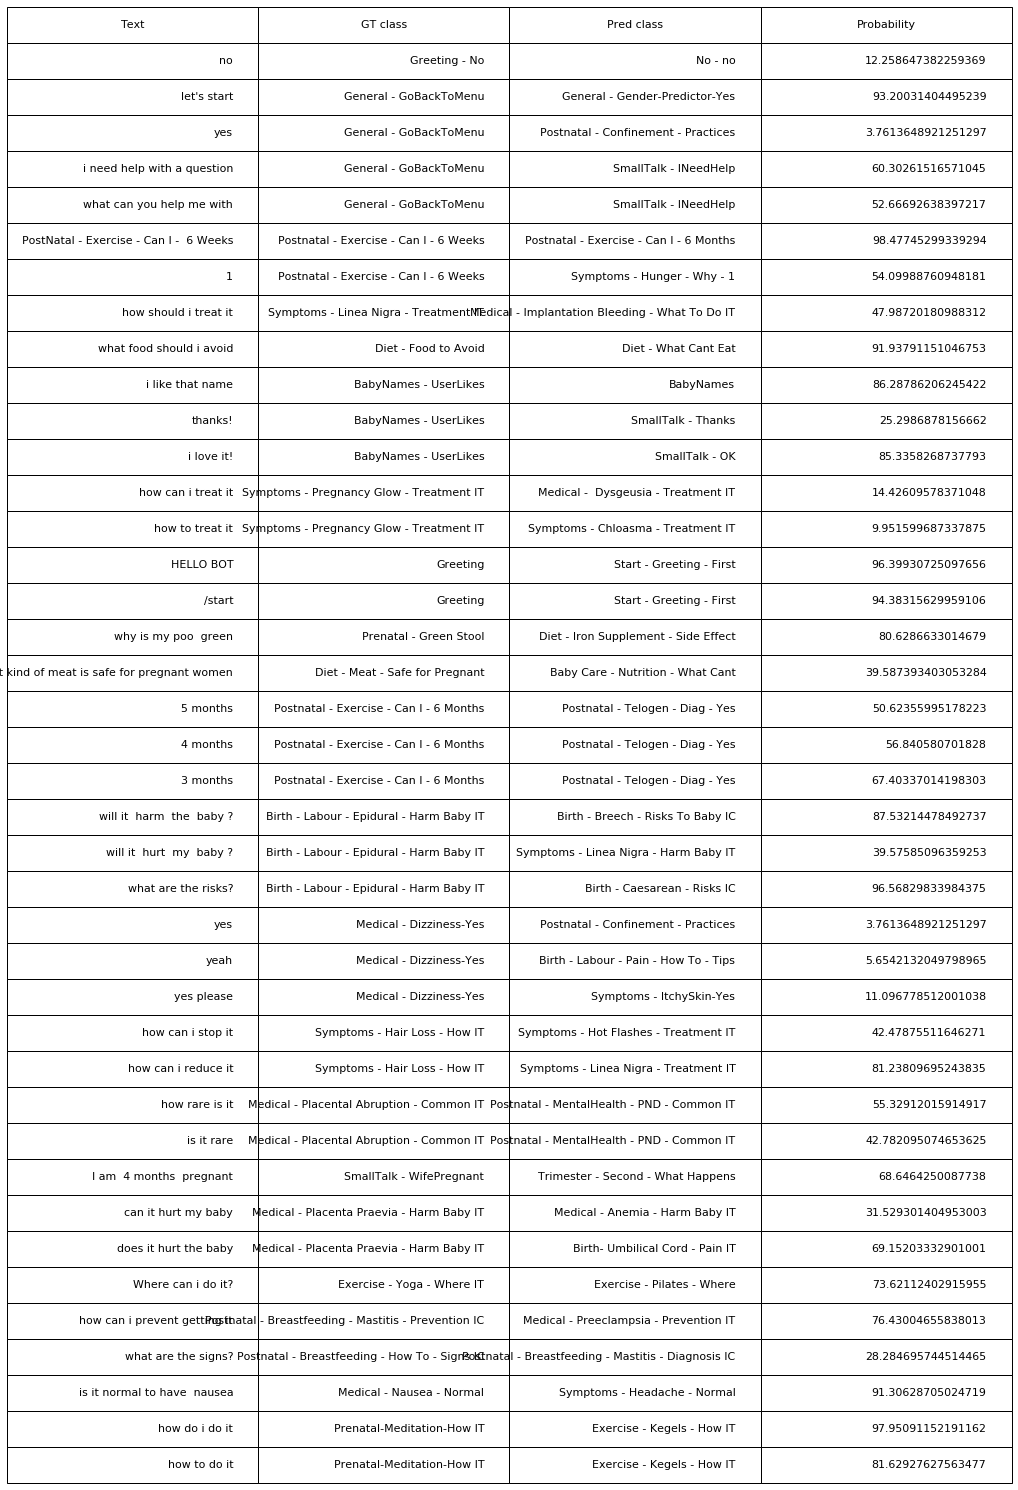

In [10]:
import matplotlib.pyplot as plt

print('Found %s (accuracy: %s) misassigned examples. Showing the top 40' \
    % (len(cell_text), 1 - round(len(cell_text) / len(X_data) * 100, 2)))

if len(cell_text) > 0:
    table = plt.table(cellText=cell_text[:40],
              colLabels=['Text', 'GT class', 'Pred class', 'Probability'],
              loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(3,3)
    plt.axis('off')
    plt.show()